# Setup Environment

In [1]:
# Modify the pathname

pathname = '/content/drive/MyDrive/MMAI/MMAI 891 - NLP/NLP Topic Classification/'

In [2]:
# Connect and Mount Google Drive if needed

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Install packages

%%capture

!pip install tensorflow
!pip install -q transformers tfds-nightly
!pip install optuna
!pip install -U sentence-transformers

In [4]:
# Set Seed 

seed_value=123

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
# Import libraries

import matplotlib.pyplot as plt
import pandas as pd

from transformers import DistilBertTokenizer, TFDistilBertModel

from keras.layers import Dense, Input, Dropout

import tensorflow_datasets as tfds

from tensorflow import keras
from keras import regularizers 

from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Adam

from sentence_transformers import SentenceTransformer


from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

from wordcloud import WordCloud

import re
import spacy
from nltk.tokenize import word_tokenize

from collections import Counter
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

import optuna
from optuna.integration import LightGBMPruningCallback

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load and Split Data

In [6]:
def load_data():

    df = pd.read_csv(pathname+'public_data.csv')

    return df

data = load_data()
data.head(3)

,id,message,label
0,5396,I made a purchase recently but I have decided ...,request_refund
1,2202,"Cancel my transfer, please.",cancel_transfer
2,3768,How do I change my last name?,edit_personal_details


In [7]:
def split_data(df):

    X = df['message']
    y = df['label']
  
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=123)

    return X_train_, X_test_, y_train_, y_test_

X_train, X_test, y_train, y_test = split_data(data)
display(X_train.shape)
display(X_test.shape)

(8372,)

(2094,)

# EDA

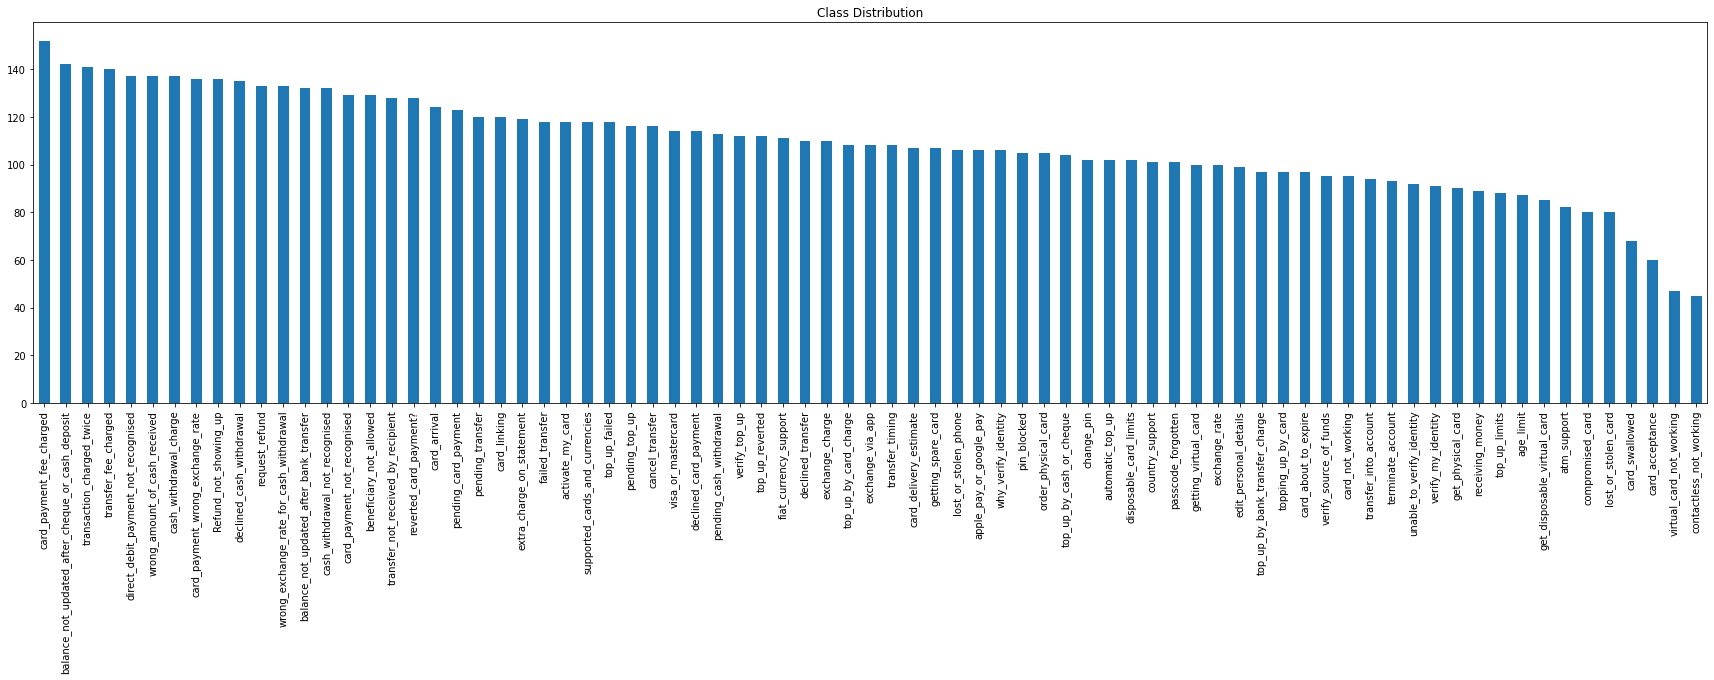

In [8]:
# Class Distribution

y_train.value_counts().plot.bar(figsize=(30,7))
plt.title('Class Distribution')
plt.show()

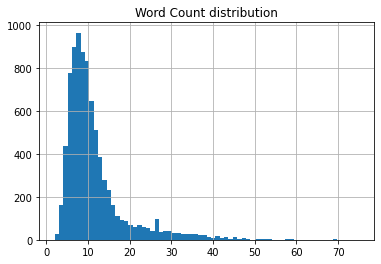

In [9]:
# number of words

X_train.str.split().map(lambda x: len(x)).hist(bins=70)
plt.title('Word Count distribution')
plt.show()

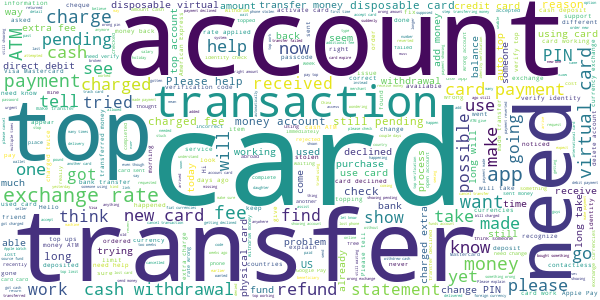

In [10]:
# Word Cloud

# Join the different processed titles together.
long_string = ','.join(list(X_train.values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=10000, width=600, height=300, contour_width=10, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

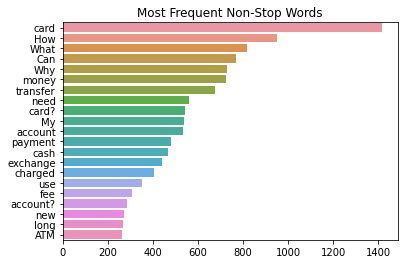

In [11]:
# Top non-stopwords

new=X_train.str.split().values.tolist()
corpus=[word for i in new for word in i]

en = spacy.load('en_core_web_sm')
stop = en.Defaults.stop_words
stop = list(stop)+['I','i','is','Is']

counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:65]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

plt.title('Most Frequent Non-Stop Words')
plt.show()

# Shallow Model: LightGBM with TfIdf

In [12]:
# 1) Converts text to lower case
# 2) Removes stop-words using spacy
# 3) Removes all characters except the alphabet 

def clean_text(X):

    X = X.apply(lambda x: x.lower())

    en = spacy.load('en_core_web_sm')
    stop = en.Defaults.stop_words
    X = X.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    X = X.apply(lambda x: re.sub(r'[^a-zA-Z ]', '',x))

    return X

In [13]:
# Tokenization and Tf-Idf Vectorization

class vectorize(BaseEstimator, TransformerMixin):
    
    def __init__(self,tfidf=None):
        self.tfidf = tfidf
        
    def fit(self, X, y=None):
        
        X1 = X.copy()
        self.tfidf = TfidfVectorizer(strip_accents='unicode',
                          tokenizer=word_tokenize,
                          ngram_range=(1,2),
                          max_df=0.5,
                          min_df=0.002)
        self.tfidf.fit(X1)
        
        return self

    def transform(self, X):

        X1 = X.copy()
        X1 = self.tfidf.transform(X1)
        X1 = pd.DataFrame(X1.toarray())
        inv_map = {v: k for k, v in self.tfidf.vocabulary_.items()}
        X1.rename(columns=inv_map,inplace=True)
        
        return X1


In [14]:
# Select Features using Recursive Feature Elimination

class select_features(BaseEstimator, TransformerMixin):
    
    def __init__(self, rfe=None, n=None, est=None):
        self.rfe = rfe
        self.n = n
        self.est = est
        
    def fit(self, X, y):
        
        X1 = X.copy()
        y1 = y.copy()
        self.rfe = RFE(estimator=self.est, step=10000, n_features_to_select=self.n)
        self.rfe.fit(X1,y1)
        
        return self

    def transform(self, X):

        X1 = X.copy()
        X1 = X1.loc[:,self.rfe.support_]

        return X1

In [15]:
# Use Optuna for tuning LightGBM with pruning callbacks

class Objective:
    
    def __init__(self):
        self.best_booster = None
        self._booster = None
    
    def __call__(self, trial, X, y):
        
        param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=100),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.1),
        "num_leaves": trial.suggest_int('num_leaves', 16, 4096),
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
        "max_bin": trial.suggest_int("max_bin", 50, 500, step=10),
        "lambda_l1": trial.suggest_loguniform('lambda_l1', 1e-6, 1),
        "lambda_l2": trial.suggest_loguniform('lambda_l2', 1e-6, 1),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 0.1),
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.7, 1),
        "bagging_freq": trial.suggest_int('bagging_freq', 1, 10),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.5, 1),
        "early_stopping_rounds": trial.suggest_categorical("early_stopping_rounds", [100]),
        }

        param2 = {"n": trial.suggest_int("n", 50, 500, step=10)}
              
        pipe_a = Pipeline(steps=[('vectorize', vectorize()),
                                 ('select_features', select_features(**param2,est=LGBMClassifier()))])
        pipe_b = Pipeline(steps=[('modeler', LGBMClassifier(objective='multiclass', **param_grid, random_state=123))])
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
        cv_scores = np.empty(5)
    
        for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            X_train = clean_text(X_train)
            X_val = clean_text(X_val)

            pipe_a.fit(X_train,y_train)
            X_train = pipe_a.transform(X_train)
            X_val = pipe_a.transform(X_val)

            pipe_b.fit(
                X_train,
                y_train,
                modeler__eval_set=[(X_val,y_val)],
                modeler__eval_metric='multi_logloss',
                modeler__callbacks=[LightGBMPruningCallback(trial, "multi_logloss")],
                modeler__verbose=0
            )

            preds = pipe_b.predict(X_val)
            cv_scores[idx] = accuracy_score(y_val, preds)
        
        self._booster = pipe_b['modeler']
        
        return np.mean(cv_scores)

    def callback(self, study, trial):
        
        if study.best_trial == trial:
            self.best_booster = self._booster


def optuna_tuning(X, y, ntrials):
    
    objective = Objective()

    study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=1),
                            direction="minimize", study_name="LGBM Classifier")
    func = lambda trial: objective(trial, X, y)
    study.optimize(func, n_trials=ntrials, callbacks=[objective.callback])

    for key, value in study.best_params.items():
        print(f"\t\t{key}: {value}")   
    
    print('Best value: ',study.best_value)
    print('Best iterations: ',objective.best_booster.best_iteration_)


In [16]:
# # Call the tuning function (commented out so that it doesn't execute on Run All)

# optuna_tuning(X_train, y_train, 100) # uncomment for tuning

In [17]:
# Best hyperparameters from Optuna tuning - 

best_params = {'n_estimators': 300,
		'learning_rate': 0.009465650002016093,
		'num_leaves': 256,
		'max_depth': 8,
		'min_data_in_leaf': 5,
		'max_bin': 120,
		'lambda_l1': 1.1064189698586584e-05,
		'lambda_l2': 2.786200972607006e-05,
		'min_gain_to_split': 0.02051948470231614,
		'bagging_fraction': 0.9291430999126205,
		'bagging_freq': 5,
		'feature_fraction': 0.7293508287762191,
		'n': 300}

In [18]:
# Retrain model on full Training data using best hyperparameters

def retrain(X_train_, y_train_):
    
    X_train_ = clean_text(X_train_)

    model1 = LGBMClassifier(objective='multiclass',**best_params, random_state=123)

    pipe_ = Pipeline(steps=[('vectorize', vectorize()),
                      ('select_features', select_features(n=best_params['n'], est=LGBMClassifier())),
                      ('modeler', model1)])

    pipe_.fit(X_train_,y_train_)

    return pipe_, X_train_, y_train_

pipe, X_train1, y_train1 = retrain(X_train, y_train)

In [19]:
# Test Model

def test_model(pipe_, X_train_, y_train_, X_test_, y_test_):

    fitted = pipe_.predict(X_train_)
    print('Train Accuracy: ', accuracy_score(y_train_, fitted))

    X_test_ = clean_text(X_test_)
    preds = pipe_.predict(X_test_)
    print('Test Accuracy: ', accuracy_score(y_test_, preds))    

test_model(pipe, X_train1, y_train1, X_test, y_test)

Train Accuracy:  0.9445771619684663
Test Accuracy:  0.7139446036294174


# Hybrid Model - LightGBM with SBERT encodings

In [20]:
%%capture

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [21]:
def encode_text(X):

    X = X.apply(lambda x: sbert_model.encode(x))
    X = X.apply(pd.Series)

    return X

X_train1 = encode_text(X_train)

In [22]:
# Use Optuna for tuning LightGBM with pruning callbacks

class Objective2:
    
    def __init__(self):
        self.best_booster = None
        self._booster = None
    
    def __call__(self, trial, X, y):
        
        param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [50,100,300]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int('num_leaves', 16, 128),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100, step=5),
        "max_bin": trial.suggest_int("max_bin", 10, 50),
        "lambda_l1": trial.suggest_loguniform('lambda_l1', 1e-6, 10),
        "lambda_l2": trial.suggest_loguniform('lambda_l2', 1e-6, 10),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 1),
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.3, 0.9),
        "bagging_freq": trial.suggest_int('bagging_freq', 1, 5),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.2, 0.8),
        "early_stopping_rounds": trial.suggest_categorical("early_stopping_rounds", [100]),
        }

        param2 = {"n": trial.suggest_int("n", 50, 300, step=10)}

        pipe_a = Pipeline(steps=[('select_features', select_features(**param2, est=LGBMClassifier()))])
        pipe_b = Pipeline(steps=[('modeler', LGBMClassifier(objective='multiclass', **param_grid, random_state=123))])
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
        cv_scores = np.empty(5)
    
        for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            pipe_a.fit(X_train,y_train)
            X_train = pipe_a.transform(X_train)
            X_val = pipe_a.transform(X_val)

            pipe_b.fit(
                X_train,
                y_train,
                modeler__eval_set=[(X_val,y_val)],
                modeler__eval_metric='multi_logloss',
                modeler__callbacks=[LightGBMPruningCallback(trial, "multi_logloss")],
                modeler__verbose=0
            )

            preds = pipe_b.predict(X_val)
            cv_scores[idx] = accuracy_score(y_val, preds)
        
        self._booster = pipe_b['modeler']
        
        return np.mean(cv_scores)

    def callback(self, study, trial):
        
        if study.best_trial == trial:
            self.best_booster = self._booster


def optuna_tuning2(X, y, ntrials):
    
    objective = Objective2()

    study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=1),
                            direction="minimize", study_name="LGBM Classifier")
    func = lambda trial: objective(trial, X, y)
    study.optimize(func, n_trials=ntrials, callbacks=[objective.callback])

    for key, value in study.best_params.items():
        print(f"\t\t{key}: {value}")   
    
    print('Best value: ',study.best_value)
    print('Best iterations: ',objective.best_booster.best_iteration_)


In [23]:
# # Call the tuning function (commented out so that it doesn't execute on Run All)

# optuna_tuning2(X_train1, y_train, 100) # uncomment for tuning

In [24]:
# Best hyperparameters from Optuna tuning

best_params = {'n_estimators': 100, 
               'learning_rate': 0.07492604515955112,
								'num_leaves': 42, 
								'max_depth': 6, 
								'min_data_in_leaf': 125, 
								'max_bin': 26, 
								'lambda_l1': 0.18444616280624587, 
								'lambda_l2': 0.27499128330945698, 
								'min_gain_to_split': 0.2021432257519862, 
								'bagging_fraction': 0.4322962210982496, 
								'bagging_freq': 4, 
								'feature_fraction': 0.3472868578035121, 
								'n': 200}


In [25]:
# Retrain model on full Training data using best hyperparameters

def retrain2(X_train_, y_train_):
    
    model1 = LGBMClassifier(objective='multiclass',**best_params, random_state=123)

    pipe_ = Pipeline(steps=[('select_features', select_features(n=best_params['n'],est=model1)),
                      ('modeler', model1)])

    pipe_.fit(X_train_,y_train_)

    return pipe_, X_train_,y_train_

pipe, X_train1, y_train1 = retrain2(X_train1, y_train)

In [26]:
# Test Model

def test_model2(pipe_, X_train_,y_train_, X_test_, y_test_):

    fitted = pipe_.predict(X_train_)
    print('Train Accuracy: ', accuracy_score(y_train_, fitted))

    X_test_ = encode_text(X_test_)    
    preds = pipe_.predict(X_test_)
    print('Test Accuracy: ', accuracy_score(y_test_, preds))

test_model2(pipe, X_train1, y_train1, X_test, y_test)

Train Accuracy:  0.973124701385571
Test Accuracy:  0.8127984718242598


# DistilBERT

In [27]:
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [28]:
# Split train data into train and val
# Encode target using label binarizer

def prep_data(X,y):

    # Encode Target
    lb1 = preprocessing.LabelBinarizer()
    y_train_val_ = lb1.fit_transform(y)
    
    X_train_val_ = X_train.copy()

    X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_val_, y_train_val_, test_size=0.2, random_state=123)

    return X_train_, X_val_, y_train_, y_val_, X_train_val_, y_train_val_, lb1

X_train1, X_val1, y_train1, y_val1, X_train_val, y_train_val, lb = prep_data(X_train,y_train)

In [29]:
# Encode text using dbert_tokenizer

def encode_text(X):

    text = [x for x in  X]
    output = dbert_tokenizer(text, return_tensors='tf', padding='max_length', truncation=True, max_length=64)
    input_ids = output["input_ids"]
    attention_mask = output["attention_mask"]

    return input_ids, attention_mask

train_input, train_mask = encode_text(X_train1)
val_input, val_mask = encode_text(X_val1)

In [30]:
def build_model(base_model, trainable, train_in, dropout1):

    max_seq_len = train_in.shape[1]

    inputs = Input(shape=(max_seq_len,),name='inputs', dtype=tf.int64)
    masks = Input(shape=(max_seq_len,),name='masks', dtype=tf.int64)

    base_model.trainable = trainable

    dbert_output = base_model(inputs, attention_mask=masks)
    # dbert_last_hidden_state gets you the output encoding for each of your tokens.
    # Each such encoding is a vector with 768 values. The first token fed into the model is [cls]
    # which can be used to build a sentence classification network
    dbert_last_hidden_state = dbert_output.last_hidden_state

    dbert = dbert_last_hidden_state[:,0,:]

    my_output = Dropout(dropout1)(dbert)

    probs = Dense(77, activation='sigmoid')(my_output)

    model = keras.Model(inputs=[inputs, masks], outputs=probs)
    model.summary()

    return model

dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

model = build_model(dbert_model, trainable=True, train_in=train_input, dropout1=0.5)


Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 64)]         0           []                               
                                                                                                  
 masks (InputLayer)             [(None, 64)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['inputs[0][0]',                 
 BertModel)                     ast_hidden_state=(N               'masks[0][0]']                  
                                one, 64, 768),                                                    
                                 hidden_states=None                                           

In [31]:
def compile_model(model):
    
    loss = keras.losses.CategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss=[loss, loss], metrics=CategoricalAccuracy('accuracy'))

    return model

model = compile_model(model)

In [32]:
def train_model(model1, train_input, train_mask, y_train, y_val, val_input, val_mask, batch_size, num_epochs):
    
    history = model1.fit([train_input,train_mask], y_train, 
                        validation_data=([val_input,val_mask],y_val),
                        batch_size=batch_size, epochs=num_epochs, verbose=1,)
    
    return history

history = train_model(model, train_input, train_mask, y_train1,
                             y_val1, val_input, val_mask,
                             batch_size=256, 
                             num_epochs=5,
                             )

Epoch 1/5
27/27 [==============================] - 33s 940ms/step - loss: 3.2758 - accuracy: 0.2356 - val_loss: 1.3033 - val_accuracy: 0.6812
Epoch 2/5
27/27 [==============================] - 24s 887ms/step - loss: 0.9766 - accuracy: 0.7469 - val_loss: 0.5943 - val_accuracy: 0.8376
Epoch 3/5
27/27 [==============================] - 24s 888ms/step - loss: 0.4529 - accuracy: 0.8789 - val_loss: 0.4166 - val_accuracy: 0.8884
Epoch 4/5
27/27 [==============================] - 24s 887ms/step - loss: 0.2443 - accuracy: 0.9356 - val_loss: 0.3920 - val_accuracy: 0.8967
Epoch 5/5
27/27 [==============================] - 24s 888ms/step - loss: 0.1514 - accuracy: 0.9636 - val_loss: 0.3537 - val_accuracy: 0.9057


In [33]:
# Retrain model on full dataset

def retrain_model(X_train_, y_train_, model1):
  
    all_input, all_mask = encode_text(X_train_)

    model1.fit([all_input, all_mask], y_train_, batch_size=256, epochs=5)
  
    return model1

model_final = retrain_model(X_train_val, y_train_val, model)

Epoch 1/5
33/33 [==============================] - 28s 833ms/step - loss: 0.1716 - accuracy: 0.9565
Epoch 2/5
33/33 [==============================] - 28s 834ms/step - loss: 0.0970 - accuracy: 0.9753
Epoch 3/5
33/33 [==============================] - 28s 834ms/step - loss: 0.0540 - accuracy: 0.9885
Epoch 4/5
33/33 [==============================] - 28s 835ms/step - loss: 0.0380 - accuracy: 0.9921
Epoch 5/5
33/33 [==============================] - 28s 835ms/step - loss: 0.0324 - accuracy: 0.9933


In [71]:
# Test Model

def predict_test(model1, X_test_, y_test_, lb_encoder):

    test_input, test_mask = encode_text(X_test_)

    pred = model1.predict([test_input, test_mask])

    pred2=lb_encoder.inverse_transform(pred)

    print('Test Accuracy: ', accuracy_score(y_test_, pred2))

    clf = classification_report(y_test_, pred2, output_dict=True)
    report = pd.DataFrame(clf).T
    report = report[:-3].sort_values('f1-score')

    return report

clf_report = predict_test(model_final, X_test, y_test, lb)

Test Accuracy:  0.9173829990448902


In [74]:
pd.set_option('display.max_rows', 100)
print('Lowest 5 F1 Scores:')
display(clf_report.head())
print('\n')
print('Highest 5 F1 Scores:')
display(clf_report.tail())


Lowest 5 F1 Scores:


,precision,recall,f1-score,support
topping_up_by_card,0.652174,0.882353,0.750000,17.0
pending_transfer,1.000000,0.633333,0.775510,30.0
top_up_failed,0.710526,0.900000,0.794118,30.0
transfer_not_received_by_recipient,0.744681,0.853659,0.795455,41.0
pending_top_up,0.960000,0.685714,0.800000,35.0




Highest 5 F1 Scores:


,precision,recall,f1-score,support
apple_pay_or_google_pay,1.0,1.0,1.0,27.0
top_up_limits,1.0,1.0,1.0,22.0
visa_or_mastercard,1.0,1.0,1.0,26.0
age_limit,1.0,1.0,1.0,33.0
getting_virtual_card,1.0,1.0,1.0,10.0
